In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%config InlineBackend.figure_format = 'retina'
import torch
from second.sphere.visual import depth_to_3D
from second.sphere.conv import init_depth_from_feature
from second.protos import pipeline_pb2
from google.protobuf import text_format

from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.pytorch.train import build_network


from second.sphere.visual import *
from second.sphere.transform import *


In [2]:
#config
config_path="configs/car.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
    
config.train_input_reader.batch_size=1
input_cfg = config.train_input_reader
eval_input_cfg = config.eval_input_reader
model_cfg = config.model.second
train_cfg = config.train_config

In [15]:
# build all objects
device="cuda"
net = build_network(model_cfg, False).to(device)
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=False,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)

voxelmap_shape =  (64, 512, 512)
dense_shape =  [1, 64, 512, 512, 16]
input sparse_shape =  [ 65 512 512]
rpn debug, final_num_filters =  384
rpn debug, num_cls =  2
rpn debug, num_anchor_per_loc =  2
{'Car': 5}
[-1]
load 2207 Pedestrian database infos
load 14357 Car database infos
load 734 Cyclist database infos
load 1297 Van database infos
load 488 Truck database infos
load 224 Tram database infos
load 337 Misc database infos
load 56 Person_sitting database infos
After filter database:
load 2207 Pedestrian database infos
load 13442 Car database infos
load 734 Cyclist database infos
load 1297 Van database infos
load 488 Truck database infos
load 224 Tram database infos
load 337 Misc database infos
load 56 Person_sitting database infos
feautres size [1, 128, 128]
res = (1, 128, 128, 1, 2, 7)
feautres size [1, 128, 128]
res = (1, 128, 128, 1, 2, 7)
remain number of infos: 3712


In [16]:
dataset[0]['points']

array([[ 1.8324e+01,  4.9000e-02,  8.2900e-01,  0.0000e+00],
       [ 1.8344e+01,  1.0600e-01,  8.2900e-01,  0.0000e+00],
       [ 5.1299e+01,  5.0500e-01,  1.9440e+00,  0.0000e+00],
       ...,
       [ 6.2720e+00, -4.0000e-02, -1.6370e+00,  3.0000e-01],
       [ 6.2740e+00, -3.1000e-02, -1.6370e+00,  3.1000e-01],
       [ 6.2760e+00, -1.1000e-02, -1.6380e+00,  3.1000e-01]],
      dtype=float32)

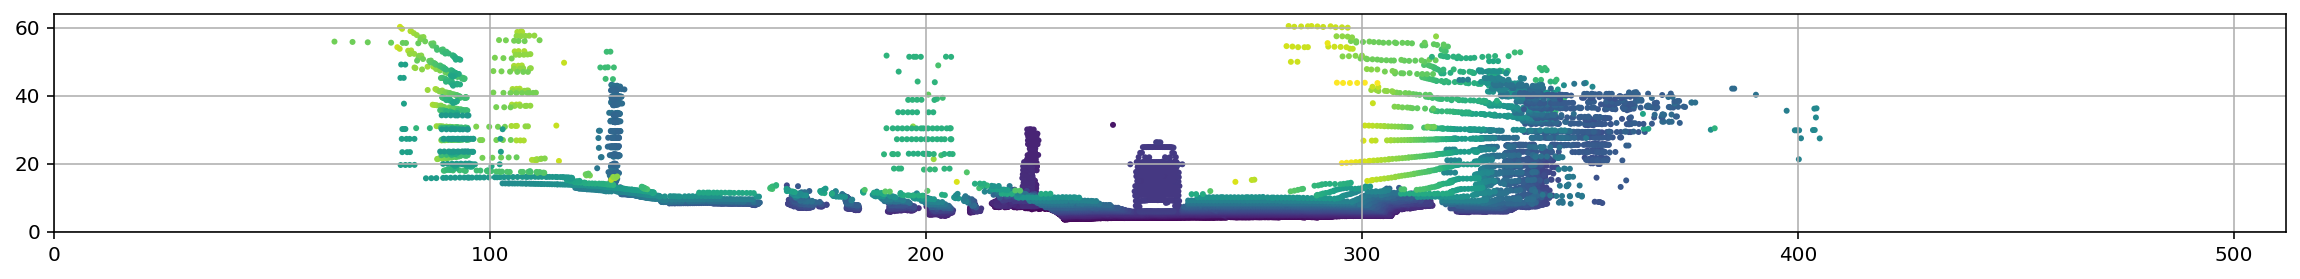

In [159]:
# front view
points = dataset[156]['points']
x = points[:,0]
y = points[:,1]
z = points[:,2]
rfl = points[:,3]


# range view
delta_theta = np.radians( 103.4 - 87.5 ) / 64
delta_phi = np.radians(90) / 512
x2y2 = x * x + y * y
r = np.sqrt(x2y2 + z * z)
theta = np.arccos( z / r);
phi = np.arcsin(y / np.sqrt(x2y2))
theta_idx = - theta / delta_theta
phi_idx = phi / delta_phi


plt.figure(figsize=(20,2))
plt.scatter((y[::-1] +40)/ 80 * 512, (z[::-1] + 2) / 5 * 64 ,c=r[::-1], alpha=1,marker='.', linewidths=0.0)

plt.xlim(0,512)
plt.ylim(0,64)
plt.grid()

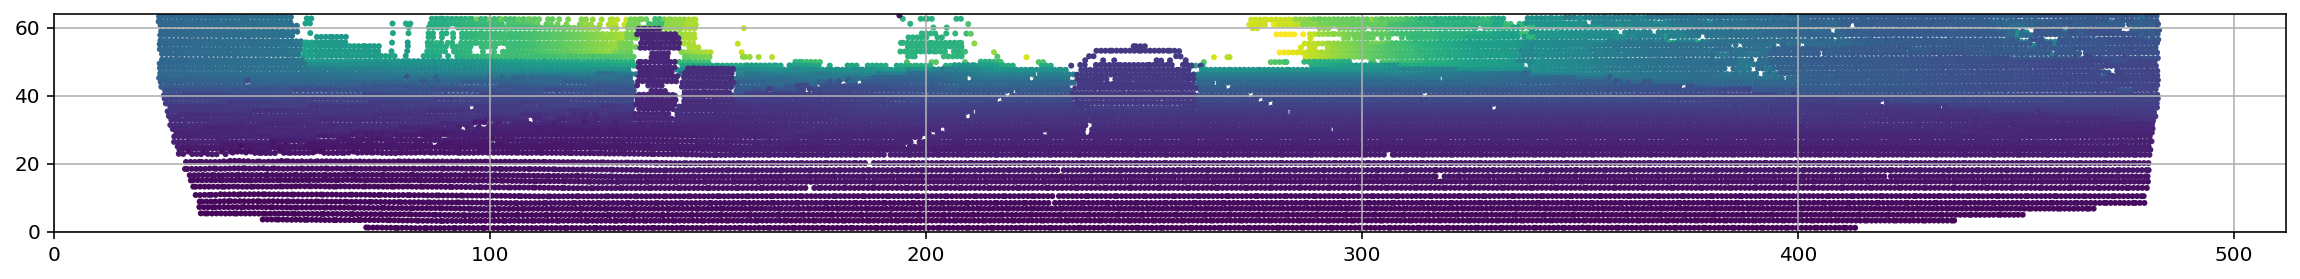

In [149]:

#depth_idx = 
plt.figure(figsize=(20,2))
plt.scatter(phi_idx + np.radians(45) / delta_phi , theta_idx + np.radians(103.4)/delta_theta, c=r+(rfl), alpha=1,marker='.', linewidths=0.0)
plt.xlim(0,512)
plt.ylim(0,64)
plt.grid()

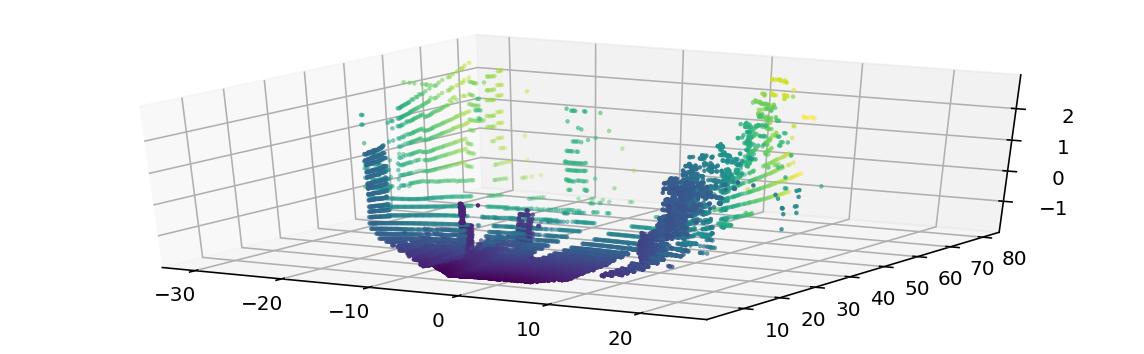

In [158]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[::-1],x[::-1],z[::-1], c=r[::-1], marker='.', linewidths=0.0)

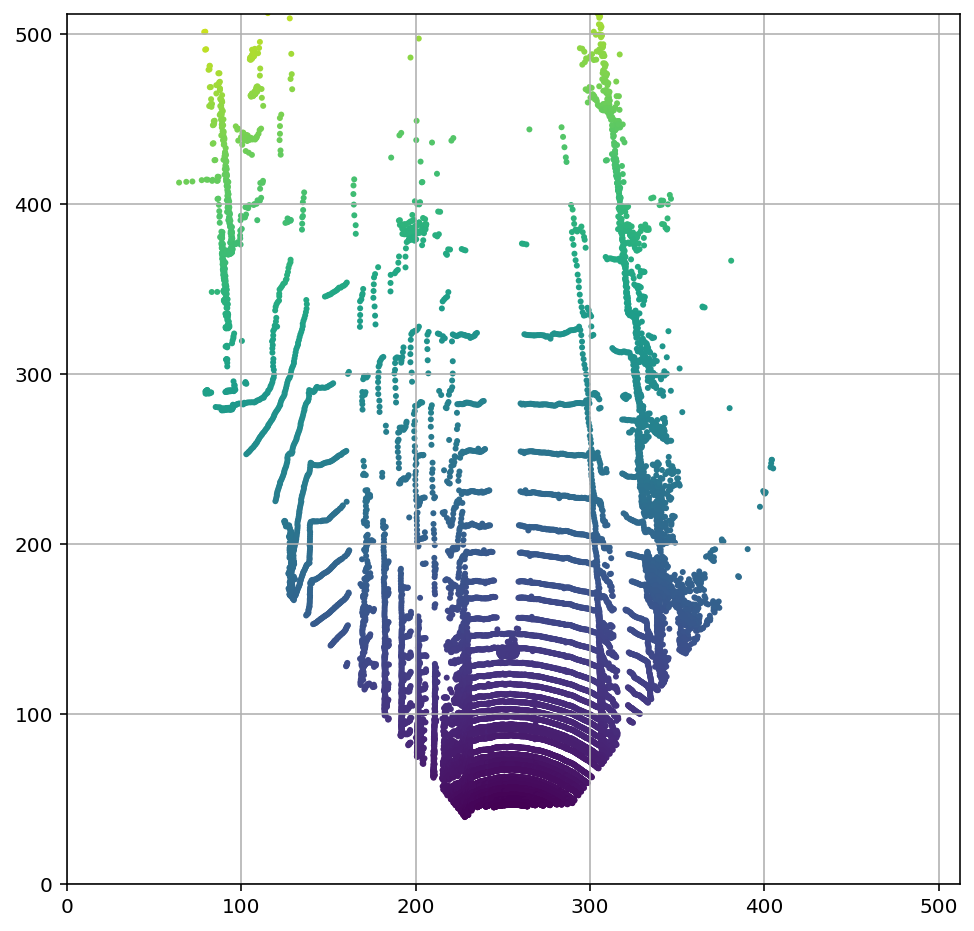

In [151]:
plt.figure(figsize=(8,8))
plt.scatter((y +40)/ 80 * 512, (x) / 70 * 512 ,c=r+rfl, alpha=1,marker='.', linewidths=0.0)

plt.xlim(0,512)
plt.ylim(0,512)
plt.grid()

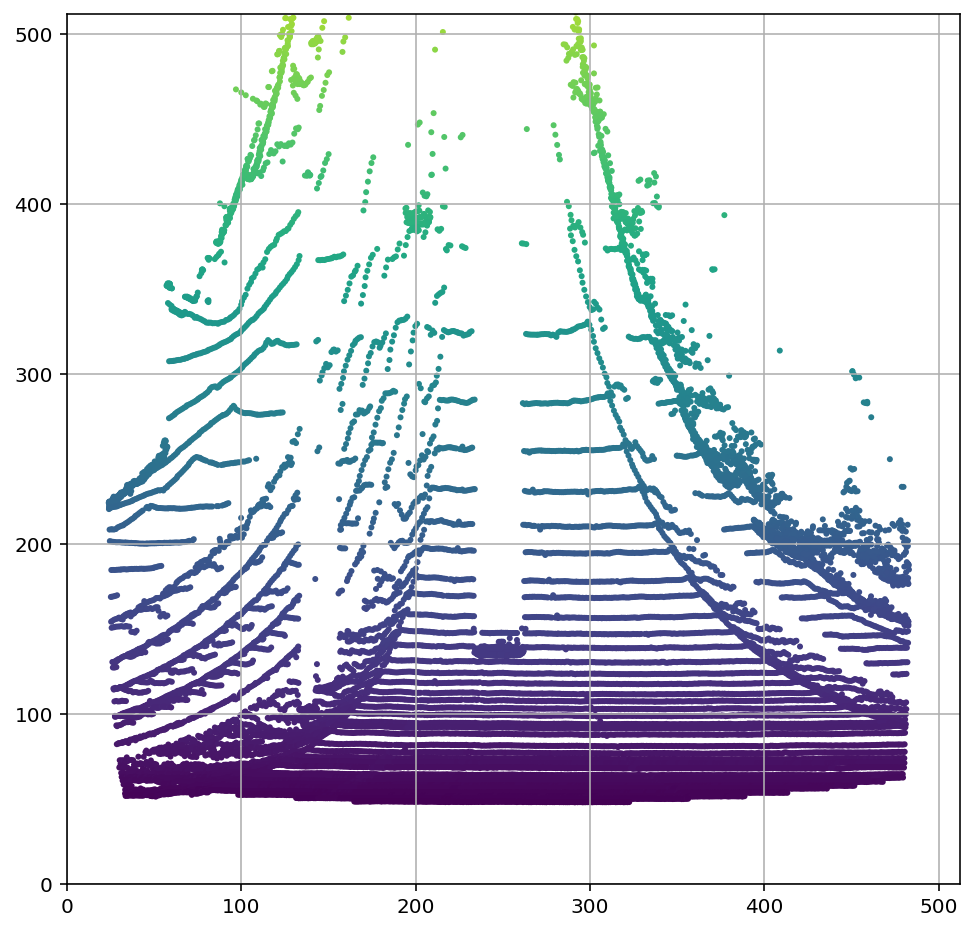

In [152]:
plt.figure(figsize=(8,8))
plt.scatter(phi_idx + 256, (r) / 70 * 512 ,c=r+rfl, alpha=1,marker='.', linewidths=0.0)

plt.xlim(0,512)
plt.ylim(0,512)
plt.grid()

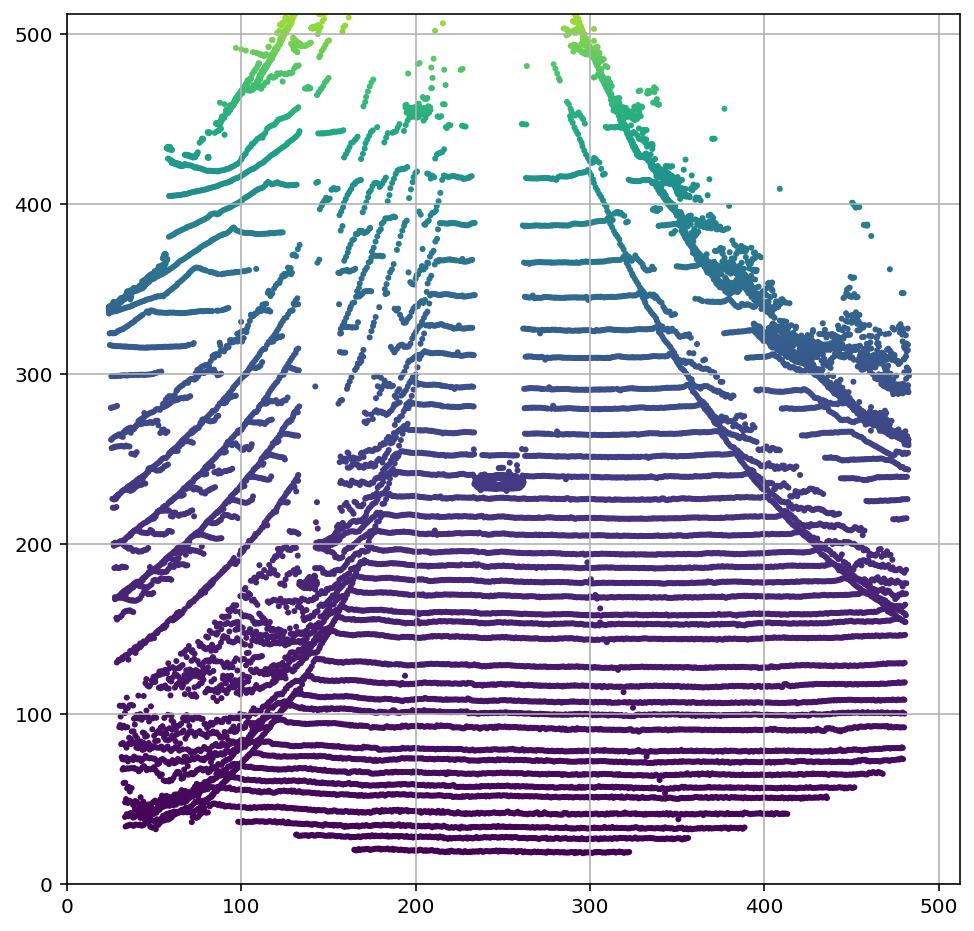

In [154]:
plt.figure(figsize=(8,8))
delta_r = (np.log(70.4) - np.log(6)) / 512
depth_idx =  (np.log(r) - np.log(6))/ delta_r
plt.scatter(phi_idx + 256, depth_idx  ,c=r+rfl, alpha=1,marker='.', linewidths=0.0)
plt.xlim(0,512)
plt.ylim(0,512)
plt.grid()